## 比赛标题
Exp6: 基于集成学习的 Amazon 用户评论质量预测

## 比赛描述

本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。需要大家完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器使用 SVM 和决策树两种，对结果进行对比分析。


## 比赛介绍

### 案例背景

随着电商平台的兴起，以及疫情的持续影响，线上购物在我们的日常生活中扮演着越来越重要的角色。在进行线上商品挑选时，评论往往是我们十分关注的一个方面。然而目前电商网站的评论质量参差不齐，甚至有水军刷好评或者恶意差评的情况出现，严重影响了顾客的购物体验。因此，对于评论质量的预测成为电商平台越来越关注的话题，如果能自动对评论质量进行评估，就能根据预测结果避免展现低质量的评论。本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。

### 任务

本案例中需要完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器要求使用 SVM 和决策树两种，因此，一共需要对比四组结果（[AUC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) 作为评价指标）：

* Bagging + SVM
* Bagging + 决策树
* AdaBoost.M1 + SVM
* AdaBoost.M1 + 决策树

注意集成学习的核心算法需要**手动进行实现**，基分类器可以调库。

### 基本要求

* 根据数据格式设计特征的表示
* 汇报不同组合下得到的 AUC
* 结合不同集成学习算法的特点分析结果之间的差异
* （使用 sklearn 等第三方库的集成学习算法会酌情扣分）

### 扩展要求

* 尝试其他基分类器（如 k-NN、朴素贝叶斯）
* 分析不同特征的影响
* 分析集成学习算法参数的影响
* 尝试各种方法提升排行榜上预测性能




## 赛题说明
### 数据描述

本次数据来源于 Amazon 电商平台，包含超过 50,000 条用户在购买商品后留下的评论，各列的含义如下：

* reviewerID：用户 ID
* asin：商品 ID
* reviewText：英文评论文本
* overall：用户对商品的打分（1-5）
* votes_up：认为评论有用的点赞数（只在训练集出现）
* votes_all：该评论得到的总评价数（只在训练集出现）
* label：评论质量的 label，1 表示高质量，0 表示低质量（只在训练集出现）

评论质量的 label 来自于其他用户对评论的 votes，votes_up/votes_all ≥ 0.9 的作为高质量评论。此外测试集包含一个额外的列`Id`，标识了每一个测试的样例。

### 文件说明

* train.csv：训练集
* test.csv：测试集，用户和商品保证在训练集中出现过，没有关于 votes 和 label 的列

文件使用 \t 分隔，可以使用 pandas 进行读取：

```python
import pandas as pd
train_df = pd.read_csv('train.csv', sep='\t')
```

### 提交格式

提交文件需要对测试集中每一条评论给出预测为高质量的**概率**，每行包括一个`Id`（和测试集对应）以及预测的概率`Predicted`（0-1的浮点数），用逗号分隔。示例提交格式如下：

```
Id,Predicted
0,0.9
1,0.45
2,0.78
...
```

提交文件需要命名为`result.csv`

## 一、提取特征

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('data\\train.csv', sep='\t')
test_df = pd.read_csv('data\\test.csv', sep='\t')
train_df

,reviewerID,asin,reviewText,overall,votes_up,votes_all,label
0,7885,3901,"First off, allow me to correct a common mistak...",5.0,6,7,0
1,52087,47978,I am really troubled by this Story and Enterta...,3.0,99,134,0
2,5701,3667,A near-perfect film version of a downright glo...,4.0,14,14,1
3,47191,40892,Keep your expectations low. Really really low...,1.0,4,7,0
4,40957,15367,"""they dont make em like this no more...""well.....",5.0,3,6,0
...,...,...,...,...,...,...,...
57034,58315,29374,"If you like beautifully shot, well acted films...",2.0,12,21,0
57035,23328,45548,This is a great set of films Wayne did Fox and...,5.0,15,18,0
57036,27203,42453,It's what's known as a comedy of manners. It's...,3.0,4,5,0
57037,33992,44891,Ellen can do no wrong as far a creating wonder...,5.0,4,5,0


In [3]:
test_df

,Id,reviewerID,asin,reviewText,overall
0,0,82947,37386,I REALLY wanted this series but I am in SHOCK ...,1.0
1,1,10154,23543,I have to say that this is a work of art for m...,4.0
2,2,5789,5724,Alien 3 is certainly the most controversal fil...,3.0
3,3,9198,5909,"I love this film...preachy? Well, of course i...",5.0
4,4,33252,21214,Even though I previously bought the Gamera Dou...,5.0
...,...,...,...,...,...
11203,11203,18250,35309,I honestly never heard of the graphic novel un...,5.0
11204,11204,3200,2130,Archie Bunker's command to stifle YOURSELF! wa...,5.0
11205,11205,37366,41971,"In LSD - My Problem Child, Albert Hoffman wrot...",5.0
11206,11206,1781,33089,I have owned this DVD for over a year now and ...,5.0


In [8]:
train_df.describe()

,reviewerID,asin,overall,votes_up,votes_all,label
count,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000
mean,33359.761865,19973.170866,3.535178,12.387594,18.475850,0.226196
std,30016.804127,14104.410152,1.529742,45.130499,50.149683,0.418371
min,50.000000,0.000000,1.000000,0.000000,5.000000,0.000000
25%,9235.000000,8218.000000,2.000000,4.000000,6.000000,0.000000
50%,22589.000000,17635.000000,4.000000,6.000000,10.000000,0.000000
75%,53170.000000,30875.000000,5.000000,11.000000,18.000000,0.000000
max,123767.000000,50051.000000,5.000000,6084.000000,6510.000000,1.000000


In [5]:
#为了避免过拟合，将ID等特征分为20类，并投影到[0,1]上

discrete_train_df = train_df.copy()
discrete_train_df['asin'] = pd.cut(discrete_train_df['asin'], bins = 20,labels = False)
discrete_train_df['reviewerID'] = pd.cut(discrete_train_df['reviewerID'], bins = 20,labels = False)
discrete_train_df['asin'] = discrete_train_df['asin'] / max(discrete_train_df['asin'])
discrete_train_df['reviewerID'] = discrete_train_df['reviewerID'] / discrete_train_df['reviewerID'].max()
discrete_train_df['overall'] = discrete_train_df['overall'] / 5.0


discrete_test_df = test_df.copy()
discrete_test_df['asin'] = pd.cut(discrete_test_df['asin'], bins = 20,labels = False)
discrete_test_df['reviewerID'] = pd.cut(discrete_test_df['reviewerID'], bins = 20,labels = False)
discrete_test_df['asin'] = discrete_test_df['asin'] / discrete_test_df['asin'].max()
discrete_test_df['reviewerID'] = discrete_test_df['reviewerID'] / discrete_test_df['reviewerID'].max()
discrete_test_df['overall'] = discrete_test_df['overall'] / 5.0



# discreteAsin =  np.floor(train_df['asin'] / 2000)
# discreteAsin =  discreteAsin / max(discreteAsin)
# discreteID = np.floor(train_df['reviewerID'] / 5000)
# discreteID = discreteID / max(discreteID)
# discreteOverall = train_df['overall'] / 5

# test_discreteAsin =  np.floor(test_df['asin'] / 2000)
# test_discreteAsin =  test_discreteAsin / max(test_discreteAsin)
# test_discreteID = np.floor(test_df['reviewerID'] / 5000)
# test_discreteID = test_discreteID / max(test_discreteID)
# test_discreteOverall = test_df['overall'] / 5

In [15]:
discrete_train_df['asin']

0        0.052632
1        1.000000
2        0.052632
3        0.842105
4        0.315789
           ...   
57034    0.578947
57035    0.947368
57036    0.842105
57037    0.894737
57038    0.368421
Name: asin, Length: 57039, dtype: float64

(array([2063.,    0., 1327.,    0., 1366.,    0.,    0., 1850.,    0.,
        4602.]),
 array([0.2 , 0.28, 0.36, 0.44, 0.52, 0.6 , 0.68, 0.76, 0.84, 0.92, 1.  ]),
 <a list of 10 Patch objects>)

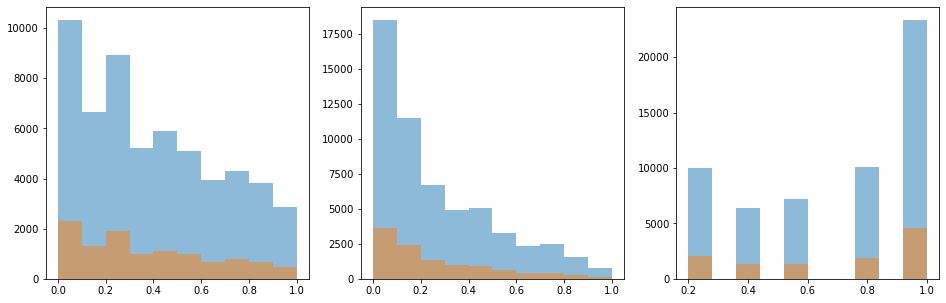

In [21]:
figure, axes = plt.subplots(1, 3, figsize = (16,5))
axes[0].hist(discrete_train_df['asin'], alpha = 0.5)
axes[0].hist(discrete_test_df['asin'], alpha = 0.5)
axes[1].hist(discrete_train_df['reviewerID'], alpha = 0.5)
axes[1].hist(discrete_test_df['reviewerID'], alpha = 0.5)
axes[2].hist(discrete_train_df['overall'], alpha = 0.5)
axes[2].hist(discrete_test_df['overall'], alpha = 0.5)

从图中可以发现，离散后的asin, reviewerID和overall在训练集和测试集基本是同分布的。

In [22]:
y_train = train_df['label']

In [23]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer

#将reviewText转化成稀疏矩阵
print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X_train_text = vectorizer.fit_transform(train_df['reviewText'])
duration = time() - t0
print("done in %fs" % duration)
print("n_samples: %d, n_features: %d" % X_train_text.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test_text = vectorizer.transform(test_df['reviewText'])
duration = time() - t0
print("done in %fs " % duration)
print("n_samples: %d, n_features: %d" % X_test_text.shape)
print()

Extracting features from the training data using a sparse vectorizer
done in 28.291456s
n_samples: 57039, n_features: 153746

Extracting features from the test data using the same vectorizer
done in 5.050851s 
n_samples: 11208, n_features: 153746



In [24]:
feature_names = vectorizer.get_feature_names()

In [48]:
#选取最好的50个特征
from sklearn.feature_selection import SelectKBest, chi2
print("Extracting 50 best features by a chi-squared test" )
t0 = time()
ch2 = SelectKBest(chi2, k=50)
X_train = ch2.fit_transform(X_train_text, y_train)
X_test = ch2.transform(X_test_text)

new_feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
print("done in %fs" % (time() - t0))
print()

Extracting 50 best features by a chi-squared test
done in 0.487126s



In [49]:
print(new_feature_names)

['abs', 'audio', 'bad', 'band', 'beginner', 'beginners', 'boring', 'calories', 'cardio', 'collection', 'concert', 'dance', 'dvd', 'dvds', 'episodes', 'excellent', 'exercises', 'fitness', 'highly', 'included', 'instruction', 'instructor', 'intermediate', 'movements', 'moves', 'muscles', 'music', 'poses', 'print', 'prints', 'quality', 'section', 'segments', 'series', 'set', 'songs', 'sound', 'stupid', 'tape', 'toning', 'vhs', 'video', 'videos', 'waste', 'weights', 'wonderful', 'workout', 'workouts', 'worst', 'yoga']


In [50]:
#系数矩阵中储存的特征数量
X_train_text,X_train, X_test_text, X_test 

(<57039x153746 sparse matrix of type '<class 'numpy.float64'>'
 	with 5386169 stored elements in Compressed Sparse Row format>,
 <57039x50 sparse matrix of type '<class 'numpy.float64'>'
 	with 112919 stored elements in Compressed Sparse Row format>,
 <11208x153746 sparse matrix of type '<class 'numpy.float64'>'
 	with 1047597 stored elements in Compressed Sparse Row format>,
 <11208x50 sparse matrix of type '<class 'numpy.float64'>'
 	with 20983 stored elements in Compressed Sparse Row format>)

In [51]:
#对文本特征进行降维 #太慢了还没有做
# from sklearn.manifold import TSNE
# from sklearn.manifold import SpectralEmbedding
# t0 = time()
# method= SpectralEmbedding(n_components=3)
# X_train_embedded = method.fit_transform(X_train)
# print("done in %fs" % (time() - t0))
# X_train_embedded.shape

In [52]:
# t0 = time()
# X_test_embedded =  method.transform(X_test)
# print("done in %fs" % (time() - t0))

In [53]:
print(train_df['reviewerID'].shape, X_train.shape)

(57039,) (57039, 50)


In [54]:
X_train.max(), X_test.max()

(0.8760007715975809, 0.9019965239627862)

In [8]:
from time import time
# t0 = time()

# # 字数计数:计算文本中记号的数量(用空格分隔)
# discrete_train_df['word_count'] = discrete_train_df["reviewText"].apply(lambda x: len(str(x).split(" "))) 

# # 字符计数:将每个标记的字符数相加计算
# discrete_train_df['char_count'] = discrete_train_df["reviewText"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

# # 句子数:计算句子的数量(以句点分隔)
# discrete_train_df['sentence_count'] = discrete_train_df["reviewText"].apply(lambda x: len(str(x).split("."))) 

# # 平均字数:字数除以字数的总和(字符数/字数)
# discrete_train_df['avg_word_length'] = discrete_train_df['char_count'] /discrete_train_df['word_count'] 

# # 平均句子长度:句子长度的总和除以句子的数量(字数/句子数量)
# discrete_train_df['avg_sentence_lenght'] = discrete_train_df['word_count'] / discrete_train_df['sentence_count']

# print("done in %fs" % (time() - t0))

# discrete_train_df.head()

def counts(df):
    print("count begins")
    t0 = time()
    # 字数计数:计算文本中记号的数量(用空格分隔)
    df['word_count'] = df["reviewText"].apply(lambda x: len(str(x).split(" "))) 
    # 字符计数:将每个标记的字符数相加计算
    df['char_count'] = df["reviewText"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
    # 句子数:计算句子的数量(以句点分隔)
    df['sentence_count'] = df["reviewText"].apply(lambda x: len(str(x).split("."))) 
    # 平均字数:字数除以字数的总和(字符数/字数)
    df['avg_word_length'] = df['char_count'] / df['word_count'] 
    # 平均句子长度:句子长度的总和除以句子的数量(字数/句子数量)
    df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
    print("done in %fs" % (time() - t0))

def discrete_counts(df, df1,  num = 11): #训练集的测试集标准不一样，应该要改成一样的 
    discretedf_train = df.copy()
    discretedf_test = df1.copy()
    for c in df.columns[1:]: # 遍历每一列特征，跳过前面的列
        if c == 'word_count' or c == 'char_count' or c == 'sentence_count' or c == 'avg_word_length' or c == 'avg_sentence_length':
            # 离散化特征
            discretedf_train[c], bins = pd.qcut(df[c], q = num,labels = False, retbins=True)
            discretedf_test[c] = pd.cut(df[c], bins = bins,labels = False)
            
            #归一化
            maxx = discretedf_train[c].max()
            discretedf_train[c] = discretedf_train[c]/ maxx
            discretedf_test[c] = discretedf_test[c]/ maxx
        
    return discretedf_train, discretedf_test

classes = 11
counts(discrete_train_df)
counts(discrete_test_df)
# discrete_train_df, discrete_test_df = discrete_counts(discrete_train_df, discrete_test_df, classes)
discrete_train_df.head()

count begins
done in 7.414235s
count begins
done in 1.377843s


,reviewerID,asin,reviewText,overall,votes_up,votes_all,label,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,0.052632,0.052632,"First off, allow me to correct a common mistak...",1.0,6,7,0,416,1987,13,4.776442,32.000000
1,0.421053,1.000000,I am really troubled by this Story and Enterta...,0.6,99,134,0,477,2225,21,4.664570,22.714286
2,0.000000,0.052632,A near-perfect film version of a downright glo...,0.8,14,14,1,71,357,4,5.028169,17.750000
3,0.368421,0.842105,Keep your expectations low. Really really low...,0.2,4,7,0,117,577,14,4.931624,8.357143
4,0.315789,0.315789,"""they dont make em like this no more...""well.....",1.0,3,6,0,98,461,21,4.704082,4.666667


In [10]:
# discrete_train_df = discrete_train_df.drop(columns = 'avg_sentence_lenghth')
# discrete_test_df = discrete_test_df.drop(columns = 'avg_sentence_lenghth')
discrete_train_df.describe()

,reviewerID,asin,overall,votes_up,votes_all,label,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
count,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000
mean,0.257629,0.393775,0.707036,12.387594,18.475850,0.226196,255.126335,1187.168166,15.734778,4.598286,16.931602
std,0.254734,0.295743,0.305948,45.130499,50.149683,0.418371,242.025413,1150.945509,14.385499,0.405145,10.118088
min,0.000000,0.000000,0.200000,0.000000,5.000000,0.000000,1.000000,6.000000,1.000000,1.857143,0.373626
25%,0.052632,0.157895,0.400000,4.000000,6.000000,0.000000,100.000000,450.000000,7.000000,4.344444,12.000000
50%,0.157895,0.368421,0.800000,6.000000,10.000000,0.000000,187.000000,858.000000,12.000000,4.587021,15.826087
75%,0.421053,0.631579,1.000000,11.000000,18.000000,0.000000,325.000000,1521.000000,20.000000,4.834740,20.090909
max,1.000000,1.000000,1.000000,6084.000000,6510.000000,1.000000,4322.000000,20203.000000,386.000000,10.500000,441.000000


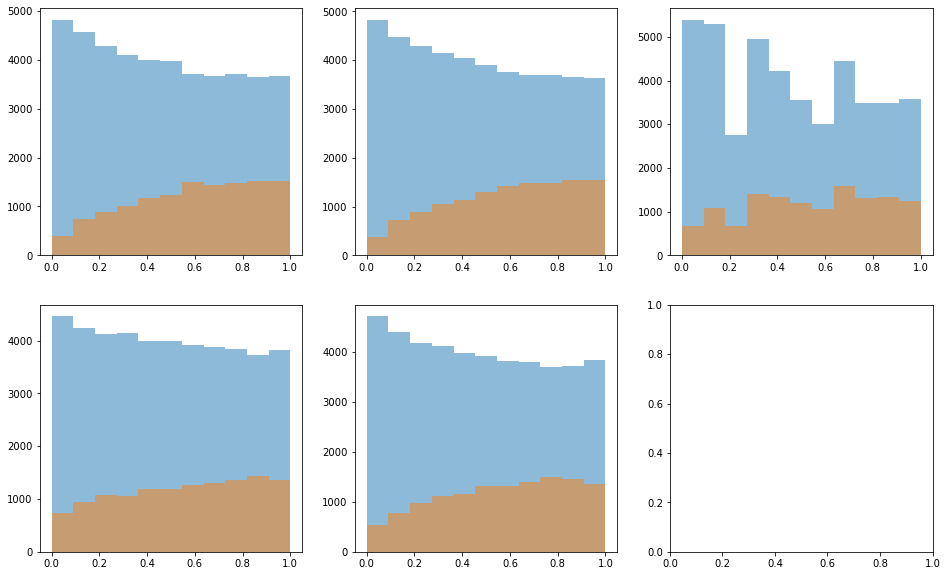

In [134]:
figure, axes = plt.subplots(2, 3, figsize = (16,10))
axes = axes.flatten()

count = ['word_count', 'char_count', 'sentence_count', 'avg_word_length', 'avg_sentence_length']
for i in range(5):
    axes[i].hist(discrete_train_df[discrete_train_df['label'] == 0][count[i]], bins = classes, alpha = 0.5)
    axes[i].hist(discrete_train_df[discrete_train_df['label'] == 1][count[i]], bins = classes, alpha = 0.5)

# plt.hist(discrete_train_df[discrete_train_df['label'] == 0]['word_count'],bins = classes, alpha = 0.5)
# plt.hist(discrete_train_df[discrete_train_df['label'] == 1]['word_count'],bins = classes, alpha = 0.5)
# print(set(discrete_train_df['word_count']))

d:\python\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
d:\python\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


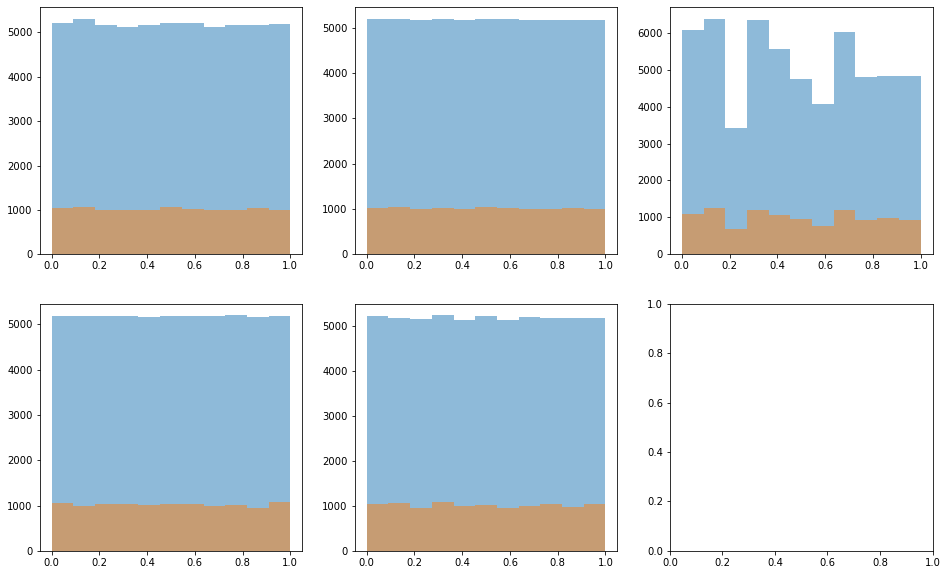

In [135]:
figure, axes = plt.subplots(2, 3, figsize = (16,10))
axes = axes.flatten()
for i in range(5):
    axes[i].hist(discrete_train_df[count[i]],bins = classes, alpha = 0.5)
    axes[i].hist(discrete_test_df[count[i]], bins = classes,alpha = 0.5)


In [137]:
# 将特征合成一个矩阵
from scipy.sparse import hstack
# train_features = hstack([np.array(discreteID).reshape(-1, 1), np.array(discreteAsin).reshape(-1, 1),
#                          X_train, np.array(discreteOverall).reshape(-1, 1)])
# test_features = hstack([np.array(test_discreteID).reshape(-1, 1), np.array(test_discreteAsin).reshape(-1, 1),
#                          X_train, np.array(test_discreteOverall).reshape(-1, 1)])

# #原有信息和文本特征
# train_features = hstack([np.array(discrete_train_df['reviewerID']).reshape(-1, 1), np.array(discrete_train_df['asin']).reshape(-1, 1),
#                           X_train, np.array(discrete_train_df['overall']).reshape(-1, 1)])
# test_features = hstack([np.array(discrete_test_df['reviewerID']).reshape(-1, 1), np.array(discrete_test_df['asin']).reshape(-1, 1),
#                          X_test, np.array(discrete_test_df['overall']).reshape(-1, 1)])

#加入文本长度等特征

count = ['word_count', 'char_count', 'sentence_count', 'avg_word_length', 'avg_sentence_length']
train_features = hstack([np.array(discrete_train_df['reviewerID']).reshape(-1, 1), np.array(discrete_train_df['asin']).reshape(-1, 1),
                          X_train, np.array(discrete_train_df['overall']).reshape(-1, 1), 
                         np.array(discrete_train_df['word_count']).reshape(-1, 1),
                         np.array(discrete_train_df['char_count']).reshape(-1, 1),
                         np.array(discrete_train_df['sentence_count']).reshape(-1, 1),
                         np.array(discrete_train_df['avg_word_length']).reshape(-1, 1),
                         np.array(discrete_train_df['avg_sentence_length']).reshape(-1, 1)])
test_features = hstack([np.array(discrete_test_df['reviewerID']).reshape(-1, 1), np.array(discrete_test_df['asin']).reshape(-1, 1),
                         X_test, np.array(discrete_test_df['overall']).reshape(-1, 1),
                         np.array(discrete_test_df['word_count']).reshape(-1, 1),
                         np.array(discrete_test_df['char_count']).reshape(-1, 1),
                         np.array(discrete_test_df['sentence_count']).reshape(-1, 1),
                         np.array(discrete_test_df['avg_word_length']).reshape(-1, 1),
                         np.array(discrete_test_df['avg_sentence_length']).reshape(-1, 1)])
test_features[np.isnan(test_features)] = 0 
train_features

<57039x58 sparse matrix of type '<class 'numpy.float64'>'
	with 525514 stored elements in COOrdinate format>

## 二、建立模型

### 2.1 定义模型

In [120]:
from sklearn.model_selection import train_test_split # 划分数据集函数(用来帮助随机采样)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB


class Guess(object):
    def __init__(self, RANDOM_SEED = 2020):
        self.RAMDOM_SEED = 2020
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        if len(X.shape) > 1: #二维数组
            rst = np.zeros(X.shape[0])
            for i, x in enumerate(X):
                 rst[i] = self.predict_(x)
        elif len(X) == 0:
            rst = -1
        else:
            rst = self.predict_(X)
        return rst
    
    def predict_(self, x):
        return 1


#Bagging 方法
class Bagging(object):
            #replicate_number拔靴采样次数，boot_size每一次采样的训练集的大小, ml选用的分类器
    def __init__(self, replicate_number = 10, boot_size = 0.6, ml = 'DecisionTreeClassifier', RANDOM_SEED = 2020): 
        self.replicate_number = replicate_number
        self.boot_size = boot_size
        self.ml = ml
        self.RANDOM_SEED = RANDOM_SEED
        
        
    def fit(self, X, y):
        self.models = list(range(self.replicate_number))
        for i in range(self.replicate_number):
            #每次用不同的random_seed采样
            ti = time()
            x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 1 - self.boot_size, random_state=self.RANDOM_SEED + i) 
            if self.ml == 'LinearSVR':
                self.models[i] = LinearSVR()
                self.models[i].fit(x_train, y_train)
            elif self.ml == 'DecisionTreeClassifier':
                self.models[i] = DecisionTreeClassifier(max_depth = 3) #为了避免过拟合，将深度设置为10
                self.models[i].fit(x_train, y_train)
            elif self.ml == 'DecisionTreeRegressor':
                self.models[i] = DecisionTreeRegressor()
                self.models[i].fit(x_train, y_train)
            elif self.ml == 'KNeighborsClassifier':
                self.models[i] = KNeighborsClassifier(n_neighbors=3)
                self.models[i].fit(x_train, y_train)
            elif self.ml == 'BernoulliNB':
                self.models[i] = BernoulliNB()
                self.models[i].fit(x_train, y_train)
            
            elif self.ml == 'LogisticRegression':
                self.models[i] = BernoulliNB()
                self.models[i].fit(x_train, y_train)
            
            else:
                self.models[i] = Guess()
                self.models[i].fit(x_train, y_train)
            print("round ", i)
            print("done in %fs" % (time() - ti))
    
    def predict(self, X): #平权投票，得出最终的predict
        rst = 0
        for i in range(self.replicate_number):
            pred = self.models[i].predict(X)
            rst += pred
        rst = rst / self.replicate_number
        
        return rst


In [47]:
#AdaBoost方法

class AdaBoost(object):
    #T 重复次数
    def __init__(self, T = 5, ml = 'DecisionTreeClassifier'): 
        self.T = T
        self.ml = ml
        
    def fit(self, X, y):
        self.models = list(range(self.T)) #分类器
        self.errors = list(range(self.T)) 
        self.betas = np.ones(self.T) * 2
        self.sample_weight = np.ones(X.shape[0]) / X.shape[0]
        for i in range(self.T):
            print("T = ", i)
            #根据权重生成模型
            ti = time()
            if self.ml == 'LinearSVR':
                self.models[i] = LinearSVR()
                self.models[i].fit(X, y, self.sample_weight)
            elif self.ml == 'DecisionTreeClassifier':
                self.models[i] = DecisionTreeClassifier(max_depth = 10)
                self.models[i].fit(X, y, self.sample_weight)
            elif self.ml == 'DecisionTreeRegressor':
                self.models[i] = DecisionTreeRegressor()
                self.models[i].fit(X, y, self.sample_weight)
            elif self.ml == 'KNeighborsClassifier':
                self.models[i] = KNeighborsClassifier(n_neighbors=3)
                self.models[i].fit(X, y, self.sample_weight)
            elif self.ml == 'BernoulliNB':
                self.models[i] = BernoulliNB()
                self.models[i].fit(X, y, self.sample_weight)
            
            elif self.ml == 'LogisticRegression':
                self.models[i] = BernoulliNB()
                self.models[i].fit(X, y, self.sample_weight)
            
            else:
                self.models[i] = Guess()
                self.models[i].fit(X, y)
            #用这个模型进行预测
            pred = self.models[i].predict(X)
            #计算所有错误分类样本权重和
            self.errors[i] = 0
            for j, pre in enumerate(pred):
                if pre != y[j]: 
                    self.errors[i] = self.errors[i] + self.sample_weight[j]
            
            print("error:", self.errors[i])
            #计算beta
            self.betas[i] = self.errors[i] / (1 - self.errors[i])
            
            if self.errors[i] > 0.5:
                print('a better C is required')
                self.T = i + 1
                return
            if self.errors[i] == 0: #如果全做对了，beta等于0.99，返回
                self.betas[i] = 0.99
                print('error = 0')
                self.T = i + 1
                return ;

            #跟新每个样本的权重，并归一化
            for j, pre in enumerate(pred):
                if pre == y[j]: 
                    self.sample_weight[j] = self.sample_weight[j] * self.betas[i]
            sumw = sum(self.sample_weight)
            print("sum of sample_weight:", sumw)
            for j, w in enumerate(self.sample_weight):
                self.sample_weight[j] = w / sumw
            print("done in %fs" % (time() - ti))
       
    def predict(self, X): #融合所有假设，各自投票权重为1/beta
        self.pollweight = np.log(1 / self.betas)
        rst = 0
        for i in range(self.T):
            pred = self.models[i].predict(X)
            rst += pred * self.pollweight[i]
        rst = rst / sum(self.pollweight)
        return rst
                   
                   

### 2.2 训练模型

In [140]:
from sklearn.metrics import roc_auc_score
#bagging + 决策树
t0 = time()
model = Bagging(ml = 'DecisionTreeClassifier')
model.fit(train_features, y_train)
print("done in %fs" % (time() - t0))

t0 = time()
pred = model.predict(train_features)
print("done in %fs" % (time() - t0))
print(pred)
print("AUC score:", roc_auc_score(y_train, pred))

round  0
done in 0.903646s
round  1
done in 0.922688s
round  2
done in 0.945331s
round  3
done in 0.892061s
round  4
done in 0.938853s
round  5
done in 0.968286s
round  6
done in 0.927207s
round  7
done in 0.964439s
round  8
done in 0.935210s
round  9
done in 0.940035s
done in 9.343560s
done in 0.306069s
[0.  0.  0.  ... 0.  0.4 0.1]
AUC score: 0.6977679649510288


In [144]:
# Bagging + LinearSVR(SVM)
t0 = time()
model2 = Bagging(ml = 'LinearSVR')
model2.fit(train_features, y_train)
print("done in %fs" % (time() - t0))

t0 = time()
pred2 = model2.predict(train_features)
print("done in %fs" % (time() - t0))
print(pred2)
print("AUC score:", roc_auc_score(y_train, pred2))

round  0
done in 2.287439s
round  1
done in 2.682568s
round  2
done in 1.770796s
round  3
done in 1.973726s
round  4
done in 2.100352s
round  5
done in 2.646968s
round  6
done in 2.309515s
round  7
done in 2.340528s
round  8
done in 2.256045s
round  9
done in 2.234341s
done in 22.604295s
done in 0.027606s
[1.55948243e-04 8.93840483e-05 8.14122478e-05 ... 8.33285168e-05
 7.66016125e-01 1.08685742e-04]
AUC score: 0.6197767466229069


In [142]:
#adaboost + 决策树
t0 = time()
model3 = AdaBoost(ml = 'DecisionTreeClassifier')
model3.fit(train_features, y_train)
print("done in %fs" % (time() - t0))
t0 = time()
pred3 = model3.predict(train_features)
print("done in %fs" % (time() - t0))
print(pred3)
roc_auc_score(y_train, pred3)

sum of sample_weight: 0.40119917950827827
T =  0
done in 5.194106s
sum of sample_weight: 0.5565274622319083
T =  1
done in 5.733508s
sum of sample_weight: 0.7399509272162568
T =  2
done in 5.181646s
sum of sample_weight: 0.7335251172038909
T =  3
done in 5.644782s
sum of sample_weight: 0.7684292691086073
T =  4
done in 5.423764s
done in 27.182788s
done in 0.166034s
[0.50365791 0.14054557 0.24527575 ... 0.14054557 0.39892773 0.64420348]


0.8283635687092246

In [143]:
#adaboost + linearSVR(SVM)
t0 = time()
model4 = AdaBoost(ml = 'LinearSVR')
model4.fit(train_features, y_train)
print("done in %fs" % (time() - t0))
t0 = time()
pred4 = model4.predict(train_features)
print("done in %fs" % (time() - t0))
print(pred4)
roc_auc_score(y_train, pred4)

a better C is required
done in 1.908395s
done in 0.002981s
[ 1.12199537e-07 -3.92700727e-07  5.93557996e-07 ... -1.69689759e-07
  1.88953182e-04  3.87520584e-06]


0.6180569443332905

### 2.3 结果分析

AUC值：
- Bagging + SVM ： 0.6197 （不稳定，每次都会变）
- Bagging + 决策树：0.6977
- AdaBoost.M1 + SVM：0.6181
- AdaBoost.M1 + 决策树：0.8284

分析：

在调整决策树深度以前，AUC一度达到0.9999左右，很明显是过拟合了，因此将最大深度设置为10。

- SVM学习器在这里很弱（应该是因为特征工程没有做好），错误率大于0.5，使得AdaBoost.M1第一轮就停了。

- SVM学习器和Bagging配合，每次AUC值都会变，甚至低于0.5，效果不理想。

- 像ID这种特征，虽然是连续的，但是其值的大小其实对label的贡献很小。

- 特征工程是存在问题的，稀疏矩阵没有离散化。因此决策树模型很可能过拟合了。

- 特别是AdaBoost.M1 + 决策树的模型，太复杂的基学习器+Adaboost, 过拟合更严重，因此在训练集上的AUC值比较大。

- 而Bagging是在训练集上随机采样，过拟合只因为决策树本身，所以也会过拟合，但没那么严重。

需要的改进：
特征工程需要重新做

## 三、其他基分类器

In [ ]:
#bagging + KNN(n = 3)
t0 = time()
model5 = Bagging(ml = 'KNeighborsClassifier')
model5.fit(train_features, y_train)
print("done in %fs" % (time() - t0))

t0 = time()
pred5 = model5.predict(train_features)
print("done in %fs" % (time() - t0))
print(pred5)
print("AUC score:", roc_auc_score(y_train, pred5))

In [59]:
#AdaBoost + KNN(n = 3)
t0 = time()
model6 = AdaBoost(ml = 'KNeighborsClassifier')
model6.fit(train_features, y_train)
print("done in %fs" % (time() - t0))

t0 = time()
pred6 = model6.predict(train_features)
print("done in %fs" % (time() - t0))
print(pred6)
print("AUC score:", roc_auc_score(y_train, pred6))

57039

In [ ]:
#Bagging + BernoulliNB
t0 = time()
model7 = Bagging(ml = 'BernoulliNB')
model7.fit(train_features, y_train)
print("done in %fs" % (time() - t0))

t0 = time()
pred7 = model7.predict(train_features)
print("done in %fs" % (time() - t0))
print(pred7)
print("AUC score:", roc_auc_score(y_train, pred7))

In [ ]:
#AdaBoost + BernoulliNB
t0 = time()
model8 = AdaBoost(ml = 'BernoulliNB', T = 20)
model8.fit(train_features, y_train)
print("done in %fs" % (time() - t0))
t0 = time()
pred8 = model8.predict(train_features)
print("done in %fs" % (time() - t0))
print(pred8)
print("AUC score:", roc_auc_score(y_train, pred8))

In [ ]:
for i in range(20):
    pred9 = model8.models[i].predict(train_features)
    print("AUC score:", roc_auc_score(y_train, pred9))

可以发现一个有趣的现象，奇数轮的AUC值在0.5左右，而偶数轮的auc值先上升后下降。

最终的AUC值大于所有单轮的AUC值。说明AdaBoost结合贝叶斯分类是有效的，但也同时存在过拟合的可能性。

## 四、采用不同特征

### 4.1 仅文本特征


In [ ]:
#adaboost + 决策树 + 仅文本
t0 = time()
model9 = AdaBoost(ml = 'DecisionTreeClassifier')
model9.fit(X_train, y_train)
print("done in %fs" % (time() - t0))
pred9 = model9.predict(X_train)
print(pred9)
print("AUC:", roc_auc_score(y_train, pred9))

### 4.2仅文本以外的离散特征

In [ ]:
discrete_f_train = np.hstack([np.array(discrete_train_df['reviewerID']).reshape(-1, 1), np.array(discrete_train_df['asin']).reshape(-1, 1),
                         np.array(discrete_train_df['overall']).reshape(-1, 1), 
                         np.array(discrete_train_df['word_count']).reshape(-1, 1),
                         np.array(discrete_train_df['char_count']).reshape(-1, 1),
                         np.array(discrete_train_df['sentence_count']).reshape(-1, 1),
                         np.array(discrete_train_df['avg_word_length']).reshape(-1, 1),
                         np.array(discrete_train_df['avg_sentence_length']).reshape(-1, 1)])
discrete_f_test = np.hstack([np.array(discrete_test_df['reviewerID']).reshape(-1, 1), np.array(discrete_test_df['asin']).reshape(-1, 1),
                         np.array(discrete_test_df['overall']).reshape(-1, 1),
                         np.array(discrete_test_df['word_count']).reshape(-1, 1),
                         np.array(discrete_test_df['char_count']).reshape(-1, 1),
                         np.array(discrete_test_df['sentence_count']).reshape(-1, 1),
                         np.array(discrete_test_df['avg_word_length']).reshape(-1, 1),
                         np.array(discrete_test_df['avg_sentence_length']).reshape(-1, 1)])

In [ ]:
#adaboost + 决策树 + 仅文本以外离散特征
t0 = time()
model10 = AdaBoost(ml = 'DecisionTreeClassifier')
model10.fit(discrete_f_train, y_train)
print("done in %fs" % (time() - t0))
pred10 = model10.predict(discrete_f_train)
print(pred10)
print("AUC:", roc_auc_score(y_train, pred10))

发现：使用仅文本以外的离散特征效果比仅采用文本特征效果更好，这很可能是文本特征没有进行离散化，因此过拟合了。

In [ ]:
test_pred = model10.predict(discrete_f_test)

test_pred = [np.argmax(x) for x in test_pred]
 
#将测试集预测结果写入文件
output=pd.DataFrame({'Id':test_df.id,'Predicted':test_pred})
output.to_csv('data/results.csv', index=None)

In [10]:
import math
from scipy.special import comb
from scipy.integrate import quad

#概率密度公式
f = lambda q, n, p: comb(n, n*q)*math.pow(p, n * q)*math.pow((1-p), n * ( 1 - q))


#求0.9 ~ 1.0的密度定积分，划分成宽度为0.1的区间求和，作为估计实际vote_up大于等于0.9的概率（即高质量评论）
ran = np.array(range(90,100))/100
rest = np.array(range(0,90))/100
def prob(qq, nn):
    p = 0
    q = qq / nn
    for i in ran:
        p = p + 1/10 * f(q, nn, i)
    ap = p
    for i in rest:
        ap = ap + 1/10 * f(q, nn, i)
    return p/ap

In [11]:
prob(15, 15)

0.8163902340048661

In [ ]:
from tqdm import tqdm
probs = []
for i in tqdm(range(len(train_df['votes_up']))):
    probs.append(prob(train_df['votes_up'][i], train_df['votes_all'][i]))

 63%|██████████████████████████████████████████████▉                            | 35684/57039 [03:02<01:50, 192.51it/s]d:\python\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
 84%|██████████████████████████████████████████████████████████████▋            | 47700/57039 [04:02<00:44, 210.08it/s]

In [122]:
probs = np.array(probs)
train_df['probs'] = probs

In [125]:
max(train_df['probs'])

0.76059945675

In [124]:
train_df

,reviewerID,asin,reviewText,overall,votes_up,votes_all,label,probs
0,7885,3901,"First off, allow me to correct a common mistak...",5.0,6,7,0,2.517396e-01
1,52087,47978,I am really troubled by this Story and Enterta...,3.0,99,134,0,6.577389e-09
2,5701,3667,A near-perfect film version of a downright glo...,4.0,14,14,1,4.917142e-01
3,47191,40892,Keep your expectations low. Really really low...,1.0,4,7,0,7.477548e-03
4,40957,15367,"""they dont make em like this no more...""well.....",5.0,3,6,0,4.658558e-03
...,...,...,...,...,...,...,...,...
57034,58315,29374,"If you like beautifully shot, well acted films...",2.0,12,21,0,1.409772e-05
57035,23328,45548,This is a great set of films Wayne did Fox and...,5.0,15,18,0,6.911284e-02
57036,27203,42453,It's what's known as a comedy of manners. It's...,3.0,4,5,0,2.065794e-01
57037,33992,44891,Ellen can do no wrong as far a creating wonder...,5.0,4,5,0,2.065794e-01


In [14]:
import scipy.stats as st


st.norm.cdf(0, loc=2, scale=1) # 均值为 2，标准差为 1 的正态分布在 0 处的累计分布概率值

st.norm.cdf([-1, 0, 1])

st.binom.cdf(90, n = 100, p = 0.85)
# st.binom.pmf(4, n=100, p=0.05)

0.9449053683077058

In [7]:
import scipy.stats as st
a = [99.3, 98.7, 100.5, 101.2, 98.3, 99.7, 99.5, 102.1, 100.5]
st.ttest_1samp(a, 100)

Ttest_1sampResult(statistic=-0.054996133220328265, pvalue=0.9574902045208937)

In [8]:
b = [1]*8+ [0]*2

In [9]:
st.ttest_1samp(b, 0.9)

Ttest_1sampResult(statistic=-0.7499999999999999, pvalue=0.4724044424553536)

In [10]:
c = [1]*1999+ [0]*20
z, p = st.ttest_1samp(c, 0.9)

In [11]:
p

1.5210544250097746e-266

数据集处理

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

#将reviewText列转化为向量
Vectorizer = TfidfVectorizer(max_features = 50, ngram_range = (1, 3))
reviewX = Vectorizer.fit_transform(train_df['reviewText'])
print(Vectorizer.get_feature_names())

KeyboardInterrupt: 

In [64]:
x = np.ones((100, 4))

In [65]:
y = np.ones(100)

In [70]:
x.shape

(100, 4)

In [67]:
model = Bagging(ml = 'LinearSVR')
model.fit(x, y)
pred = model.predict(np.array([[1, 1, 1, 1], [2, 1, 1, 1]]))

In [68]:
pred

array([1. , 1.2])

In [123]:
model = AdaBoost(ml = 'DecisionTreeRegressor')
model.fit(x, y)
pred = model.predict(np.array([[1, 1, 1, 1], [2, 1, 1, 1]]))

0
error = 0


In [124]:
pred

array([1., 1.])

In [121]:
model.pollweight

array([0.01005034, 0.        , 0.        , 0.        , 0.        ])

662904832/662903077 [==============================] - 106s 0us/step
C:\Users\Yujing\.keras\datasets\multi_cased_L-12_H-768_A-12\bert_config.json C:\Users\Yujing\.keras\datasets\multi_cased_L-12_H-768_A-12\bert_model.ckpt C:\Users\Yujing\.keras\datasets\multi_cased_L-12_H-768_A-12\vocab.txt


In [10]:
#抄作业bert

import pandas as pd
import codecs, gc
import numpy as np
from sklearn.model_selection import KFold
from keras_bert import load_trained_model_from_checkpoint, Tokenizer
from keras.metrics import top_k_categorical_accuracy
from keras.layers import *
from keras.callbacks import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
 
maxlen = 100  #设置序列长度为120，要保证序列长度不超过512
 
#预训练好的模型

config_path = 'uncased_L-12_H-768_A-12/bert_config.json'
checkpoint_path = 'uncased_L-12_H-768_A-12/bert_model.ckpt'
dict_path = 'uncased_L-12_H-768_A-12/vocab.txt'
 
#将词表中的词编号转换为字典
token_dict = {}
with codecs.open(dict_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)
 
# 重写tokenizer        
class OurTokenizer(Tokenizer):
    def _tokenize(self, text):
        R = []
        for c in text:
            if c in self._token_dict:
                R.append(c)
            elif self._is_space(c):
                R.append('[unused1]')  # 用[unused1]来表示空格类字符
            else:
                R.append('[UNK]')  # 不在列表的字符用[UNK]表示
        return R
    
tokenizer = OurTokenizer(token_dict)
 
#让每条文本的长度相同，用0填充
def seq_padding(X, padding=0):
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])
 
#data_generator只是一种为了节约内存的数据方式
class data_generator:
    def __init__(self, data, batch_size=32, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1
 
    def __len__(self):
        return self.steps
 
    def __iter__(self):
        while True:
            idxs = list(range(len(self.data)))
 
            if self.shuffle:
                np.random.shuffle(idxs)
 
            X1, X2, Y = [], [], []
            for i in idxs:
                d = self.data[i]
                text = d[0][:maxlen]
                x1, x2 = tokenizer.encode(first=text)
                y = d[1]
                X1.append(x1)
                X2.append(x2)
                Y.append([y])
                if len(X1) == self.batch_size or i == idxs[-1]:
                    X1 = seq_padding(X1)
                    X2 = seq_padding(X2)
                    Y = seq_padding(Y)
                    yield [X1, X2], Y[:, 0, :]
                    [X1, X2, Y] = [], [], []
 
# 计算top-k正确率,当预测值的前k个值中存在目标类别即认为预测正确                 
def acc_top1(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=1)
 
#bert模型设置
def build_bert(nclass):
    bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None)  #加载预训练模型
 
    for l in bert_model.layers:
        l.trainable = True
 
    x1_in = Input(shape=(None,))
    x2_in = Input(shape=(None,))
 
    x = bert_model([x1_in, x2_in])
    x = Lambda(lambda x: x[:, 0])(x) # 取出[CLS]对应的向量用来做分类
    p = Dense(nclass, activation='softmax')(x)
 
    model = Model([x1_in, x2_in], p)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(1e-5),    #用足够小的学习率
                  metrics=['accuracy', acc_top2])
    print(model.summary())
    return model
 
#训练数据、测试数据和标签转化为模型输入格式
DATA_LIST = []
for data_row in train_df.iloc[:].itertuples():
    DATA_LIST.append((data_row.reviewText, to_categorical(data_row.label, 2)))
DATA_LIST = np.array(DATA_LIST)
 
DATA_LIST_TEST = []
for data_row in test_df.iloc[:].itertuples():
    DATA_LIST_TEST.append((data_row.reviewText, to_categorical(0, 2)))
DATA_LIST_TEST = np.array(DATA_LIST_TEST)
 


In [11]:
DATA_LIST

array([["First off, allow me to correct a common mistake that was made by more than one reviewer here: This is most certainly not the first film ever made where animated characters interact with live actors. Pete's Dragon (1977), Mary Poppins (1964) and Song of the South (1946) all predate it, and if you want a lesson in cartoon history, so does Gertie the Dinosaur (1914). But that doesn't mean Who Framed Roger Rabbit is not a landmark film. It was revolutionary for its degree of interaction between the toons and the human characters, done so perfectly that they seem completely natural at first glance, but then amaze when you take a closer look - little things like Jessica Rabbit pinching Eddie Valiant's cheek, or Roger Rabbit hiding under the water in Valiant's sink, or beneath his coat, little details that took very creative special effects to be made convincing. It's also unique and original in the fact that some of it takes place in the real world, featuring animated characters, an

In [12]:
model = build_bert(2)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, None, 768)    108891648   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 768)          0           functional_3[0][0]    

In [ ]:
# train_model_pred = np.zeros((len(data), 2))
# test_model_pred = np.zeros((len(data_test), 2))

# X_train, X_valid, = data[train_fold, :], data[test_fold, :]

# train_D = data_generator(, shuffle=True)
# valid_D = data_generator(X_valid, shuffle=True)
# test_D = data_generator(data_test, shuffle=False)

# model.fit_generator(
#             train_D.__iter__(),
#             steps_per_epoch=len(train_D),
#             epochs=5,
#             validation_data=valid_D.__iter__(),
#             validation_steps=len(valid_D),
#             callbacks=[early_stopping, plateau, checkpoint],
# )


# train_model_pred[test_fold, :] = model.predict_generator(valid_D.__iter__(), steps=len(valid_D), verbose=1)
# test_model_pred += model.predict_generator(test_D.__iter__(), steps=len(test_D), verbose=1)


# train_model_pred, test_model_pred = run_cv(2, DATA_LIST, None, DATA_LIST_TEST)
 
# test_pred = [np.argmax(x) for x in test_model_pred]
 
# #将测试集预测结果写入文件
# output=pd.DataFrame({'Id':test_df.id,'Predicted':test_pred})
# output.to_csv('data/results.csv', index=None)

In [ ]:
#交叉验证训练和测试模型
def run_cv(nfold, data, data_labels, data_test):
    kf = KFold(n_splits=nfold, shuffle=True, random_state=520).split(data)
    train_model_pred = np.zeros((len(data), 2))
    test_model_pred = np.zeros((len(data_test), 2))
 
    for i, (train_fold, test_fold) in enumerate(kf):
        X_train, X_valid, = data[train_fold, :], data[test_fold, :]
 
        model = build_bert(2)
        early_stopping = EarlyStopping(monitor='val_acc', patience=3)   #早停法，防止过拟合
        plateau = ReduceLROnPlateau(monitor="val_acc", verbose=1, mode='max', factor=0.5, patience=2) #当评价指标不在提升时，减少学习率
        checkpoint = ModelCheckpoint('./bert_dump/' + str(i) + '.hdf5', monitor='val_acc',verbose=2, save_best_only=True, mode='max', save_weights_only=True) #保存最好的模型
 
        train_D = data_generator(X_train, shuffle=True)
        valid_D = data_generator(X_valid, shuffle=True)
        test_D = data_generator(data_test, shuffle=False)
        #模型训练
        model.fit_generator(
            train_D.__iter__(),
            steps_per_epoch=len(train_D),
            epochs=5,
            validation_data=valid_D.__iter__(),
            validation_steps=len(valid_D),
            callbacks=[early_stopping, plateau, checkpoint],
        )
 
        # model.load_weights('./bert_dump/' + str(i) + '.hdf5')
 
        # return model
        train_model_pred[test_fold, :] = model.predict_generator(valid_D.__iter__(), steps=len(valid_D), verbose=1)
        test_model_pred += model.predict_generator(test_D.__iter__(), steps=len(test_D), verbose=1)
 
        del model
        gc.collect()   #清理内存
        K.clear_session()   #clear_session就是清除一个session
        # break
 
    return train_model_pred, test_model_pred
 
#n折交叉验证
train_model_pred, test_model_pred = run_cv(2, DATA_LIST, None, DATA_LIST_TEST)
 
test_pred = [np.argmax(x) for x in test_model_pred]
 
#将测试集预测结果写入文件
output=pd.DataFrame({'Id':test_df.id,'Predicted':test_pred})
output.to_csv('data/results.csv', index=None)

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
functional_9 (Functional)       (None, None, 768)    108891648   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 768)          0           functional_9[0][0]   

In [166]:
import numpy as np
import pandas as pd
tryy = np.load('./data/bertf3(5).npy')

In [167]:
tryy

array([[ 0.0097396 , -0.07622716,  0.05304861, ...,  0.52224571,
         0.26489231,  1.        ],
       [-0.52637929, -0.13064612, -0.28737295, ...,  0.21315193,
         0.59075469,  1.        ],
       [-0.00975796, -0.21178283,  0.02980006, ...,  0.1959189 ,
         0.34668219,  1.        ],
       ...,
       [-0.11315919, -0.15480247, -0.49121901, ...,  0.3148703 ,
         0.42239293,         nan],
       [ 0.04391461, -0.0982058 , -0.06216805, ...,  0.36087343,
         0.10998979,         nan],
       [ 0.10511701, -0.05473848,  0.08738177, ...,  0.47462544,
         0.28318512,         nan]])

In [168]:
tryy.shape

(35208, 769)

In [171]:
labels = tryy[:,768][:24000]
sum(labels)

12000.0

In [174]:
features = tryy[:,0:768][:24000]
features

array([[ 0.0097396 , -0.07622716,  0.05304861, ..., -0.14644121,
         0.52224571,  0.26489231],
       [-0.52637929, -0.13064612, -0.28737295, ...,  0.17828295,
         0.21315193,  0.59075469],
       [-0.00975796, -0.21178283,  0.02980006, ..., -0.11723166,
         0.1959189 ,  0.34668219],
       ...,
       [ 0.18401402, -0.33296385,  0.01902012, ...,  0.00902978,
         0.54764074,  0.32343212],
       [-0.23170309, -0.17729409, -0.13758963, ..., -0.22204168,
         0.32135811,  0.36318263],
       [ 0.12418755, -0.10782202,  0.02178431, ..., -0.09299452,
         0.42526135,  0.15571694]])

In [148]:
from sklearn.preprocessing import normalize
  
features = normalize(features, axis = 0)

a = pd.DataFrame(features)
for c in a[:1]:
    a[c] = pd.cut(a[c], bins = 10, labels = False) / 10


In [149]:
features

array([[0.6, 0.6, 0.6, ..., 0.4, 0.5, 0.4],
       [0.2, 0.5, 0.3, ..., 0.7, 0.2, 0.7],
       [0.6, 0.4, 0.6, ..., 0.4, 0.2, 0.5],
       ...,
       [0.8, 0.4, 0.5, ..., 0.6, 0.6, 0.5],
       [0.7, 0.5, 0.4, ..., 0.7, 0.4, 0.4],
       [0.6, 0.6, 0.3, ..., 0.6, 0.4, 0.4]])

In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 2020)
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
   

d:\python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [176]:
print("train score:", lr_clf.score(train_features, train_labels))

pred = lr_clf.predict(test_features)
print("test score:", lr_clf.score(test_features, test_labels))


train score: 0.6792708333333334
test score: 0.6402083333333334


In [177]:
# from sklearn.model_selection import train_test_split # 划分数据集函数(用来帮助随机采样)
# from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# from sklearn.svm import LinearSVR
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import BernoulliNB


from sklearn.metrics import roc_auc_score
from time import time
#bagging + bert + logistic regression
t0 = time()
model = AdaBoost(ml = 'LogisticRegression')
model.fit(train_features, train_labels)
print("done in %fs" % (time() - t0))

t0 = time()
pred = model.predict(train_features)
print("done in %fs" % (time() - t0))
print(pred)
print("train AUC score:", roc_auc_score(train_labels, pred))

testpred = model.predict(test_features)
print("test AUC score:", roc_auc_score(test_labels, testpred))

T =  0
error: 0.3943750000000362
sum of sample_weight: 0.7887500000000881
done in 1.381310s
T =  1
error: 0.4479989009532351
sum of sample_weight: 0.8959978019064609
done in 1.396410s
T =  2
error: 0.4336594281401815
sum of sample_weight: 0.8673188562803441
done in 1.456425s
T =  3
error: 0.4785017771143575
sum of sample_weight: 0.9570035542285301
done in 1.313404s
T =  4
error: 0.4297719413482023
sum of sample_weight: 0.8595438826964671
done in 1.354405s
done in 6.903955s
done in 3.196664s
[0.23149543 0.66316066 0.4535494  ... 0.23149543 1.         0.66316066]
train AUC score: 0.673690493370761
test AUC score: 0.6475978749631071


In [178]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(train_features, train_labels)
print("train score:", clf.score(train_features, train_labels))

pred = clf.predict(test_features)
print("test score:", clf.score(test_features, test_labels))

train score: 0.8992708333333334
test score: 0.6370833333333333


In [179]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(train_features,train_labels)
print("train score:", clf.score(train_features, train_labels))

pred = clf.predict(test_features)
print("test score:", clf.score(test_features, test_labels))

d:\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


train score: 0.9997395833333333
test score: 0.5883333333333334


In [162]:
import pandas as pd
import numpy as np

# #预处理过，只有20词的content
train_df = pd.read_csv(r'data/train1.csv', sep=',')
test_df = pd.read_csv(r'data/test1.csv', sep=',')
train_df.head()

#抄作业bert

import pandas as pd
import codecs, gc
import numpy as np
from sklearn.model_selection import KFold
from keras_bert import load_trained_model_from_checkpoint, Tokenizer
from keras.metrics import top_k_categorical_accuracy
from keras.layers import *
from keras.callbacks import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
 
maxlen = 100  #设置序列长度为120，要保证序列长度不超过512
 
#预训练好的模型
config_path = 'uncased_L-12_H-768_A-12/bert_config.json'
checkpoint_path = 'uncased_L-12_H-768_A-12/bert_model.ckpt'
dict_path = 'uncased_L-12_H-768_A-12/vocab.txt'
 
#将词表中的词编号转换为字典
token_dict = {}
with codecs.open(dict_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)
 
# 重写tokenizer        
class OurTokenizer(Tokenizer):
    def _tokenize(self, text):
        R = []
        for c in text:
            if c in self._token_dict:
                R.append(c)
            elif self._is_space(c):
                R.append('[unused1]')  # 用[unused1]来表示空格类字符
            else:
                R.append('[UNK]')  # 不在列表的字符用[UNK]表示
        return R
    
tokenizer = OurTokenizer(token_dict)
 
#让每条文本的长度相同，用0填充
def seq_padding(X, padding=0):
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])
 
#data_generator只是一种为了节约内存的数据方式
class data_generator:
    def __init__(self, data, batch_size=32, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1
 
    def __len__(self):
        return self.steps
 
    def __iter__(self):
        while True:
            idxs = list(range(len(self.data)))
 
            if self.shuffle:
                np.random.shuffle(idxs)
 
            X1, X2, Y = [], [], []
            for i in idxs:
                d = self.data[i]
                text = d[0][:maxlen]
                x1, x2 = tokenizer.encode(first=text)
                y = d[1]
                X1.append(x1)
                X2.append(x2)
                Y.append([y])
                if len(X1) == self.batch_size or i == idxs[-1]:
                    X1 = seq_padding(X1)
                    X2 = seq_padding(X2)
                    Y = seq_padding(Y)
                    yield [X1, X2], Y[:, 0, :]
                    [X1, X2, Y] = [], [], []
 
# 计算top-k正确率,当预测值的前k个值中存在目标类别即认为预测正确                 
def acc_top1(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=1)
 
#bert模型设置
def build_bert(nclass):
    bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None)  #加载预训练模型
 
    for l in bert_model.layers:
        l.trainable = True
 
    x1_in = Input(shape=(None,))
    x2_in = Input(shape=(None,))
 
    x = bert_model([x1_in, x2_in])
    x = Lambda(lambda x: x[:, 0])(x) # 取出[CLS]对应的向量用来做分类
    p = Dense(nclass, activation='softmax')(x)
 
    model = Model([x1_in, x2_in], p)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(1e-5),    #用足够小的学习率
                  metrics=['accuracy', acc_top1])
    print(model.summary())
    return model

#训练数据、测试数据和标签转化为模型输入格式
DATA_LIST = []
for data_row in train_df.iloc[:].itertuples():
    DATA_LIST.append((data_row.content, to_categorical(data_row.label, 2)))
DATA_LIST = np.array(DATA_LIST)
 
DATA_LIST_TEST = []
for data_row in test_df.iloc[:].itertuples():
    DATA_LIST_TEST.append((data_row.content, to_categorical(0, 2)))
DATA_LIST_TEST = np.array(DATA_LIST_TEST)

def run_cv(nfold, data, data_labels, data_test):
    kf = KFold(n_splits=nfold, shuffle=True, random_state=520).split(data)
    train_model_pred = np.zeros((len(data), 2))
    test_model_pred = np.zeros((len(data_test), 2))
 
    for i, (train_fold, test_fold) in enumerate(kf):
        X_train, X_valid, = data[train_fold, :], data[test_fold, :]
 
        model = build_bert(2)
        early_stopping = EarlyStopping(monitor='val_acc', patience=3)   #早停法，防止过拟合
        plateau = ReduceLROnPlateau(monitor="val_acc", verbose=1, mode='max', factor=0.5, patience=2) #当评价指标不在提升时，减少学习率
        checkpoint = ModelCheckpoint('./bert_dump/' + str(i) + '.hdf5', monitor='val_acc',verbose=2, save_best_only=True, mode='max', save_weights_only=True) #保存最好的模型
 
        train_D = data_generator(X_train, shuffle=True)
        valid_D = data_generator(X_valid, shuffle=True)
        test_D = data_generator(data_test, shuffle=False)
        #模型训练
        model.fit(
            train_D.__iter__(),
            steps_per_epoch=5,
            epochs=2,
            validation_data=valid_D.__iter__(),
            validation_steps=len(valid_D),
            callbacks=[early_stopping, plateau, checkpoint],
        )
 
        # model.load_weights('./bert_dump/' + str(i) + '.hdf5')
 
        # return model
        train_model_pred[test_fold, :] = model.predict(valid_D.__iter__(), steps=len(valid_D), verbose=1)
        test_model_pred += model.predict(test_D.__iter__(), steps=len(test_D), verbose=1)
 
        del model
        gc.collect()   #清理内存
        K.clear_session()   #clear_session就是清除一个session
        # break
 
    return train_model_pred, test_model_pred
 


In [163]:
#n折交叉验证
train_model_pred, test_model_pred = run_cv(2, DATA_LIST, None, DATA_LIST_TEST)
 
test_pred = [np.argmax(x) for x in test_model_pred]
 
#将测试集预测结果写入文件
output=pd.DataFrame({'Id':test_df.id,'Predicted':test_pred})
# output.to_csv('data/results.csv', index=None)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, None, 768)    108891648   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 768)          0           functional_3[0][0]    

KeyboardInterrupt: 

In [180]:
test_pred

NameError: name 'test_pred' is not defined